In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
from pprint import pprint


from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, classification_report,confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin



from datetime import datetime,timedelta

import os
import json

#Snowflake
import sqlalchemy
import sqlalchemy.dialects.sqlite
from snowflake.sqlalchemy import URL

from IPython.display import display, HTML, Image
from subprocess import call
import gc
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

In [2]:
gc.collect()

31

In [3]:
config_file = os.path.join(os.environ['HOME'], '.snowflake_creds.json')
with open(config_file,'r') as f:
    snowflake_creds = json.load(f)

engine = sqlalchemy.create_engine(
     URL(
         account = snowflake_creds["account"],
         user = snowflake_creds["user"],
         password = snowflake_creds["password"],
         database = snowflake_creds["database"],
         schema = 'aib',
         warehouse = 'DS',
         role = 'DS',
         numpy=True             
     )
)
connection = engine.connect()

In [4]:
class ColumnSelector(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class CategoricalColumnSelector(TransformerMixin):
    def __init__(self,feats):
        self.feats = feats

    def transform(self, X, y=None):
        regstr = ''
        length = len(self.feats)
        for i,feat in enumerate(self.feats):
            regstr = regstr+'^'+feat+'_+'

            if i < length-1:
                regstr = regstr+'|'
        return X.filter(regex=regstr)

    def fit(self, X, y=None):
        return self

    def get_feature_names(self):
        return X[self.cols].columns.tolist()

class ToSparse(TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, y=None):
        return sparse.csr_matrix(X)

    def fit(self, X, y=None):
        return self


In [5]:
def build_dummies(dataframe,feats):
    df = pd.DataFrame()
    for feat in feats:
        df = pd.concat([df,pd.get_dummies(dataframe[feat],prefix=feat)],axis=1,sort=False)
    df = pd.concat([dataframe,df],axis=1,sort=False)
    df.drop(feats,axis=1,inplace=True)
    return df

def convert_string(column):
    return column.apply(lambda x: str(int(x)) if not pd.isnull(x) else 'Empty')

def best_params(grid):
    estimator = grid.best_estimator_
    pca = grid.best_estimator_.steps[1][1]
    classifier = grid.best_estimator_.steps[2][1]
    params = grid.best_params_
    score = grid.best_score_
    return estimator,pca,classifier,params,score

In [6]:
sql = """
WITH deploy_ar AS
(
  SELECT send_timestamp::DATE AS send_date,
         email,
         isp
  FROM reporting.autoresponder_engagement
  WHERE DEPLOY_ID LIKE '1FRWISK2514191106'
),
clicks AS
(
  SELECT click::DATE AS click_date,
         email,
         isp,
         COUNT(*) clicks
  FROM aib.clicks
  WHERE click::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
year_clicks AS
(
  SELECT send_date,
         t1.email,
         t1.isp,
         SUM(clicks) OVER (
         PARTITION BY t1.email,t1.isp,send_date
         ORDER BY click_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_clicks
  FROM deploy_ar AS t1
    LEFT JOIN clicks AS t2
           ON t1.email = t2.email
          AND t1.isp = t2.isp
          AND t2.click_date <= send_date
),
opens AS
(
  SELECT opendt::DATE AS open_date,
         email,
         isp,
         COUNT(*) AS opens
  FROM aib.opens
  WHERE opendt::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
year_opens AS
(
  SELECT send_date,
         t1.email,
         t1.isp,
         SUM(opens) OVER (
         PARTITION BY t1.email,t1.isp,send_date
         ORDER BY open_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_opens
  FROM deploy_ar as t1
    LEFT JOIN opens AS t2
           ON t1.email = t2.email
          AND t1.isp = t2.isp
          AND t2.open_date <= send_date
),
traverse AS
(
  SELECT traverse_ts::DATE AS traverse_date,
         email,
         COUNT(*) traverse_signal,
         SUM(CASE WHEN CONTAINS(split_part (category,'/',2),'education') THEN 1 ELSE 0 END) AS education_signal
  FROM ds_scratch.traverse_feature_collection
  WHERE traverse_ts::DATE BETWEEN '2019-01-01' AND CURRENT_DATE -1
  GROUP BY 1,
           2
),
year_signals AS
(
  SELECT send_date,
         traverse_date,
         t1.email,
         isp,
         SUM(traverse_signal) OVER (
         PARTITION BY t1.email,isp,send_date
         ORDER BY traverse_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_signals,
         SUM(education_signal) OVER (
         PARTITION BY t1.email,isp,send_date 
         ORDER BY traverse_date 
         ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS education_signals
  FROM deploy_ar AS t1
    JOIN traverse AS t2
      ON t1.email = t2.email
     AND t2.traverse_date <= send_date
),
deploy_stats AS
(
  SELECT DEPLOY_ID,
         SUM(NVL (INTERNAL_CLICKS,0) + NVL (AR_CLICKS,0)) AS clicks,
         SUM(NVL (REVENUE,0)) AS revenue
  FROM DS_PROD.SOURCE_CUBE
  GROUP BY 1
),
epc AS
(
  SELECT DEPLOY_ID,
         revenue / clicks AS epc
  FROM deploy_stats
  WHERE clicks != 0
),
L30_sends AS
(
  SELECT TRIM(JSON:email,'"') AS email,
         TRIM(JSON:isp,'"') AS isp,
         COUNT(*) AS L30_sends
  FROM aib.sends
  WHERE TIMESTAMP_REC::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
  GROUP BY 1,
           2
),
L30_clicks AS
(
  SELECT email,
         isp,
         deploy_id,
         COUNT(*) AS L30_clicks
  FROM aib.clicks
  WHERE click::DATE BETWEEN CURRENT_DATE -31 AND CURRENT_DATE -1
  GROUP BY 1,
           2,
           3
),
revenue AS
(
  SELECT email,
         isp,
         SUM(L30_clicks*epc) AS l30_revenue
  FROM L30_clicks
    JOIN epc USING (deploy_id)
  GROUP BY 1,
           2
),
click_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_clicks) AS clicks_to_date
  FROM year_clicks
  GROUP BY 1,
           2,
           3
),
open_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_opens) AS opens_to_date
  FROM year_opens
  GROUP BY 1,
           2,
           3
),
traverse_stats AS
(
  SELECT send_date,
         email,
         isp,
         MAX(total_signals) AS signals_to_date,
         MAX(education_signals) AS edu_signals_to_date
  FROM year_signals
  GROUP BY 1,
           2,
           3
),
initial AS
(
  SELECT send_date as recent_send,
         DATEDIFF(day,send_date,current_date+1) as days_from_next_send,
         current_date+1 as next_send,
         email,
         isp,
         clicks_to_date,
         opens_to_date,
         signals_to_date,
         edu_signals_to_date,
         l30_revenue,
         L30_sends,
         L30_revenue*1000.0 / L30_sends AS ecpm
  FROM deploy_ar
    LEFT JOIN click_stats USING (send_date,email,isp)
    LEFT JOIN open_stats USING (send_date,email,isp)
    LEFT JOIN traverse_stats USING (send_date,email,isp)
    LEFT JOIN l30_sends USING (email,isp)
    LEFT JOIN revenue USING (email,isp)
  WHERE L30_sends IS NOT NULL
  AND   L30_sends != 0
)
SELECT *
FROM initial
ORDER BY 2,
         1
LIMIT 100000;
"""
DF = pd.read_sql_query(sql,engine)
#DF.dropna(thresh=3,inplace=True)
DF.fillna(0,inplace=True)

In [7]:
DF.shape

(16334, 13)

In [8]:
DF.head()


,recent_send,days_from_next_send,next_send,email,first_name,isp,clicks_to_date,opens_to_date,signals_to_date,edu_signals_to_date,l30_revenue,l30_sends,ecpm
0,2019-12-25,13,2020-01-07,carla_clouse@yahoo.com,Carla,yahoo,8,24.0,2,0,1.600551,76,21.059887
1,2019-12-17,21,2020-01-07,traceerenee2103@gmail.com,Tracee,gmail,9,6.0,1,0,0.204714,32,6.397326
2,2019-12-26,12,2020-01-07,ricosalsero227@gmail.com,Rickie,gmail,133,259.0,1,0,2.314884,528,4.384249
3,2019-11-16,52,2020-01-07,jr3029333@gmail.com,Jorge,gmail,91,20.0,1,0,0.337677,70,4.823962
4,2020-01-03,4,2020-01-07,sassysandy60@gmail.com,Sandy,gmail,57,34.0,1,0,1.565213,380,4.118983


In [9]:
categorical = ['isp','recent_send']
numerical = ['clicks_to_date',
             'opens_to_date',
             'signals_to_date',
             'edu_signals_to_date',
             'days_from_next_send']
features = categorical + numerical
X = DF[features]
y = DF['ecpm']

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# Clustering Basic

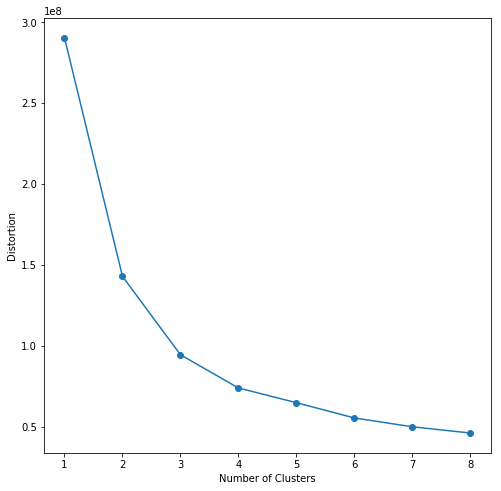

In [103]:
#determine optimal clusters k
distortions = []
for i in range(1,9):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,9),distortions,marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [104]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300)
kmeans.fit(X)
c_km = kmeans.fit_predict(X)

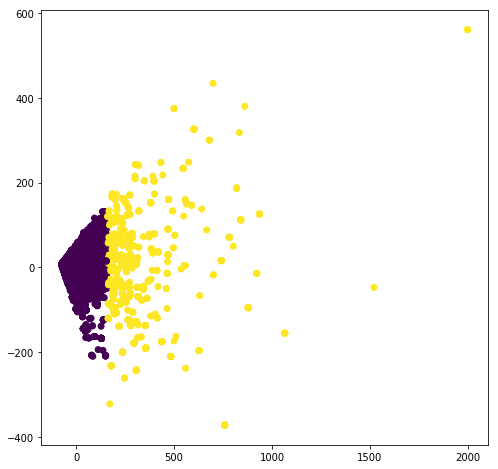

In [122]:
# Performing PCA to determine first 2 PCs
## Plot the first 2 PCs, color coded based on their cluster 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
pca_PCs = pca.transform(X)
plt.scatter(pca_PCs[:,0],pca_PCs[:,1],c=c_km)
plt.show()

In [106]:
df = X.copy()
df['cluster'] = c_km
cluster = np.unique(c_km)
## Find avg values of each cluster
averages = []
for i in cluster:
    temp_df = df.loc[df['cluster']==i]
    mean = temp_df.mean()
    averages.append(mean)

#averages for the values of each cluster
avg_df = pd.DataFrame(averages)
avg_df.head()    

,L21_CLICKS,L21_OPENS,L7_CLICKS,L7_OPENS,TRAVERSE_SIGNAL_L21,SCHOOL_TRAVERSE_L21,ALUMNI_TRAVERSE_L21,COLLEGE_TRAVERSE_L21,ISP_aol,ISP_gmail,ISP_hotmail,ISP_yahoo,cluster
0,33.315134,36.862495,10.978023,12.492656,2.992284,0.017295,0.004842,0.006386,0.013091,0.842007,0.019636,0.125266,0.0
1,225.500828,316.638245,79.835265,112.492550,9.727649,0.043046,0.009106,0.019868,0.033113,0.815397,0.073675,0.077815,1.0


In [107]:
#add cluster to features
df = X.merge(df.cluster,left_index=True,right_index=True)#.to_csv('./clustered_data_TZ4518.csv')

In [108]:
df.head(1)

,L21_CLICKS,L21_OPENS,L7_CLICKS,L7_OPENS,TRAVERSE_SIGNAL_L21,SCHOOL_TRAVERSE_L21,ALUMNI_TRAVERSE_L21,COLLEGE_TRAVERSE_L21,ISP_aol,ISP_gmail,ISP_hotmail,ISP_yahoo,cluster
0,111.0,166.0,25.0,50.0,0.0,0.0,0.0,0.0,0,1,0,0,0


# PC analysis

In [109]:
pca = PCA(n_components=2)
pca.fit(X)
pca_PCs = pca.transform(X)
print(pca.explained_variance_ratio_)

[0.84637765 0.10699123]


In [110]:
RR = X.cov()
eig_val, eig_vec = np.linalg.eig(RR)
pc_label = ['PC%d' % (i+1)for i in range(len(X.columns))]
dfEig = pd.DataFrame(eig_vec,index=X.columns,columns=pc_label)
print('EigenVectors\n')
dfEig.sort_values(['PC1','PC2'],ascending=[0,0])[['PC1','PC2']]

EigenVectors



,PC1,PC2
ISP_yahoo,1.136352e-04,-0.000052
ISP_gmail,4.245063e-05,-0.000220
ALUMNI_TRAVERSE_L21,-8.539085e-07,-0.000031
ISP_aol,-4.125979e-05,-0.000104
COLLEGE_TRAVERSE_L21,-7.003145e-05,-0.000149
SCHOOL_TRAVERSE_L21,-9.622232e-05,0.000042
ISP_hotmail,-1.148261e-04,0.000376
TRAVERSE_SIGNAL_L21,-2.356595e-02,-0.002491
L7_CLICKS,-1.865648e-01,-0.296141
L7_OPENS,-2.738420e-01,0.179809


# Modeling

In [11]:
n_components = [2,3]
param_grid = [{#'pca__n_components': n_components,
               'clf__max_depth':[1,2,3,4,5,None],
               'clf__oob_score':[False,True]}
        ]

pipe = Pipeline([
        ('features',FeatureUnion([
            ('numeric_feats',ColumnSelector(cols=numerical)),
            ('categorical_feats',Pipeline([
                ('categories',ColumnSelector(cols=categorical)),
                ('encoder',OneHotEncoder(handle_unknown='ignore')),
            ]))
        ])),
        ('ft_scale',StandardScaler(with_mean=False)),
        #('svd',TruncatedSVD(random_state=42)),
        ('clf',RandomForestRegressor(random_state=42,
                                     max_features='auto',
                                     criterion='mse',
                                     n_estimators=50))
])

In [12]:
gs_dt = GridSearchCV(pipe,
                    param_grid,
                    scoring='explained_variance',
                    return_train_score=True,
                    cv=5,n_jobs=5,verbose=3,error_score='raise')
gs_dt.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   26.2s finished


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_feats',
                                                                        <__main__.ColumnSelector object at 0x7f9d287a75d0>),
                                                                       ('categorical_feats',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('categories',
                                                                                         <__main__.ColumnSelector object at 0x7f9d287a74d0>),
                                                                                        ('encoder',
                                                   

In [13]:
estimator,pca_tree,dtree,params,score = best_params(gs_dt)
pprint(score)

0.0076382779186850765


In [14]:
def RegModelEval(DF,training=False,n=100,show=False,output='none'):
    df = DF.sample(n=n)
    y_train = df.loc[df.type == 'train'][output]
    y_train_pred = df.loc[df.type == 'train'].pred_out
    y_test = df.loc[df.type == 'test'][output]
    y_test_pred = df.loc[df.type == 'test'].pred_out
    print('R^2 Test: {:.5f}'.format(r2_score(y_test,y_test_pred)))
    print('MSE Test: {:.5f}'.format(mean_squared_error(y_test,y_test_pred)))

    if training:
        print('R^2 Train: {:.5f}'.format(r2_score(y_train,y_train_pred)))
        print('MSE Train: {:.5f}'.format(mean_squared_error(y_train,y_train_pred)))
        plt.scatter(y_train_pred[:n],(y_train_pred[:n]-y_train[:n]),c='blue',label='Training_data',marker='o')

    if show:
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.scatter(y_test_pred[:n],(y_test_pred[:n]-y_test[:n]),c='lightgreen',marker='s',label='Test_data')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        #plt.hlines(y=0,xmin=-10,xmax=10,color='red',lw=2,linestyle='-')
        #plt.xlim([-1,1])
        plt.show()

In [15]:
output = 'ecpm'
pred = estimator.predict(X_test)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df_test = pred_df.merge(DF[features+[output]],right_index=True,left_on='id')
eval_df_test['type'] = 'test'

In [16]:
pred = estimator.predict(X_train)
pred_df = pd.DataFrame(list(zip(X_test.index,pred)),columns=['id','pred_out'])
eval_df_train = pred_df.merge(DF[features+[output]],right_index=True,left_on='id')
eval_df_train['type'] = 'train'

In [17]:
eval_df = pd.concat([eval_df_test,eval_df_train])

R^2 Test: 0.00524
MSE Test: 11228.77286
R^2 Train: -0.02071
MSE Train: 1280.28376


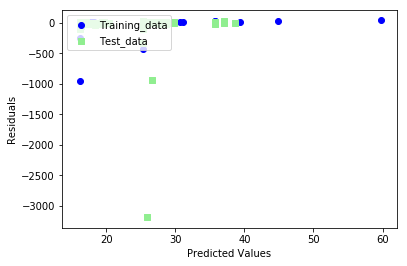

In [18]:
RegModelEval(eval_df,n=2000,show=True,training=True,output=output)

In [2]:
pickle.dump(gs_dt,open('edu_model_v1.pkl','wb'))

NameError: name 'gs_dt' is not defined

In [25]:
#loaded = pickle.load(open('edu_model_v1.pkl', 'rb'))